# Task 1 : Set up colab gpu runtime environment

In [55]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-lw2oo3_m
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-lw2oo3_m
  Resolved https://github.com/albumentations-team/albumentations to commit 0cac227d9a8f2ae7f3c0fdfd81e123208b38e924
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0
[

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

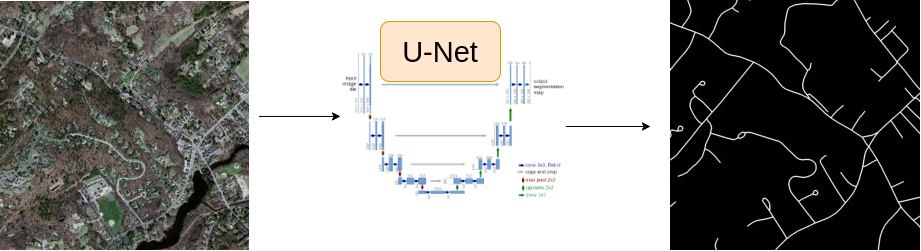

# Download Subset Dataset

# Some Common Imports

In [5]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [6]:
CSV_FILE = 'dataset.csv'
DATA_DIR = 'data'
DEVICE = 'cuda'
EPOCH = 25
LR = 1e-4
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
CSV_FILE

'dataset.csv'

In [8]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. You are using a GPU.")
else:
    print("CUDA is not available. Using CPU.")


CUDA is available. You are using a GPU.


In [9]:
df = pd.read_csv(CSV_FILE) 

print(df.head())
#ssconvert  for gnumeric type to csv 
#ssconvert dataset.csv dataset.csv

             images            masks
0  10078660_15.tiff  10078660_15.tif
1  10078675_15.tiff  10078675_15.tif
2  10078690_15.tiff  10078690_15.tif
3  10078705_15.tiff  10078705_15.tif
4  10078720_15.tiff  10078720_15.tif


In [10]:
idx = 3
image_path = DATA_DIR +'/train/images/'+ df['images'].iloc[idx]
print(image_path)
mask_path = DATA_DIR +'/train/masks/'+ df['masks'].iloc[idx]
image = cv2.imread(image_path,cv2.IMREAD_COLOR)
mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

data/train/images/10078705_15.tiff


In [11]:
import os

print(os.path.exists("data/train/images/10078705_15.tiff"))

True


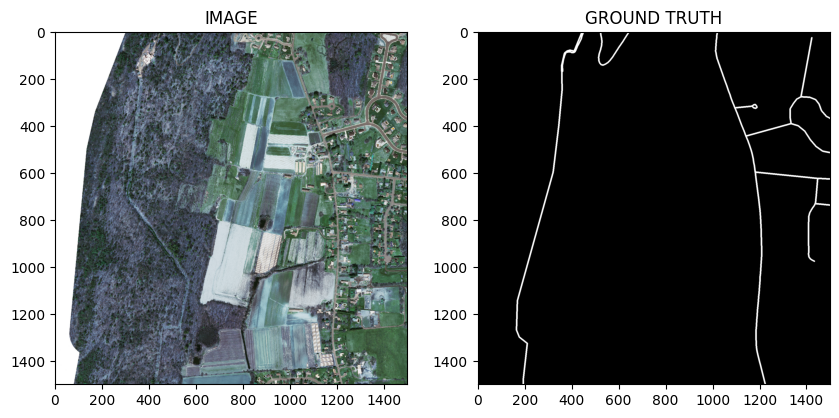

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [13]:
train_df,val_df = train_test_split(df,test_size = 0.2, random_state= 42)
len(train_df)


286

In [14]:
print(train_df.size)

572


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [15]:
import albumentations as A

In [16]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=.5),
      A.VerticalFlip(p= 0.5)
  ])
def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [17]:
from torch.utils.data import Dataset


In [19]:
class SegmentationData(Dataset):
  def __init__(self,df,augmentations):
    self.df =df
    self.augmentations = augmentations
  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = df.iloc[idx]
    image_path = DATA_DIR +'/train/images/'+ row.images
    mask_path = DATA_DIR + '/train/masks/'+row.masks
    image = cv2.imread(image_path,cv2.IMREAD_COLOR) #(h,w,c)
    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) #(h,w)
    mask = np.expand_dims(mask,axis= -1) #(h,w,c)
    #print(mask.shape)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask) #return a dictionary
      image = data['image']
      mask = data['mask']
      #print(mask.shape)

    image = np.transpose(image,(2,0,1)).astype(np.float32) #(channel,h,w)
    mask =  np.transpose(mask,(2,0,1)).astype(np.float32) #(channel,h,w)
    image = torch.tensor(image)/255 #making the float to 0 to 1
    mask = torch.round(torch.tensor(mask)/255) #making the float to 0 to 1
    return image,mask

In [20]:
train_dataset = SegmentationData(train_df,get_train_augs())
valid_dataset = SegmentationData(val_df,get_valid_augs())

In [21]:
len(train_dataset)

286

In [22]:
idx = 3
image,mask = train_dataset[idx]

In [23]:
mask.shape

torch.Size([1, 512, 512])

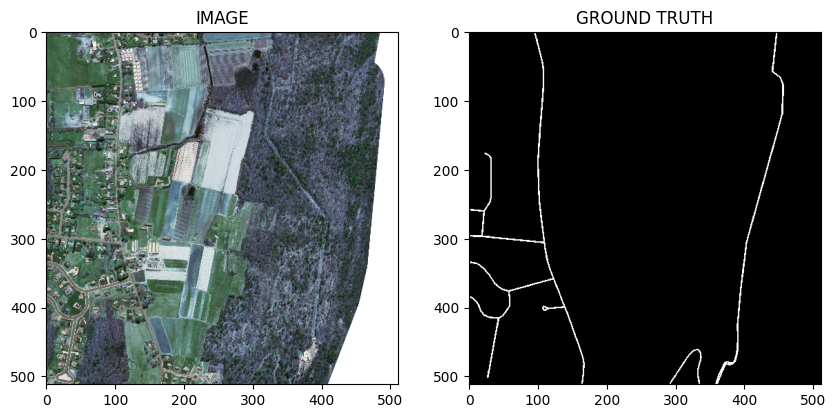

In [24]:
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [25]:
from torch.utils.data import DataLoader

In [26]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size= BATCH_SIZE)


In [27]:
print(f'Total number of images in train set : {len(train_dataset)}')
print(f'Total number of images in validation set : {len(valid_dataset)}')

Total number of images in train set : 286
Total number of images in validation set : 72


In [28]:
print(f'Total number of batches in train loader : {len(train_loader)}')
print(f'Total number of batches in validation loader : {len(valid_loader)}')

Total number of batches in train loader : 36
Total number of batches in validation loader : 9


In [29]:
for images,mask in train_loader:
  print(images.shape)
  print(mask.shape)
  break

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])


In [30]:
for images,mask in valid_loader:
  print(images.shape)
  print(mask.shape)
  break

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [31]:

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn


In [32]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self,images,masks = None):
    logits = self.backbone(images)
    if masks is not  None:
      return logits, DiceLoss(mode = 'binary')(logits,masks)+nn.BCEWithLogitsLoss()(logits,masks)

    return logits

In [33]:
model = SegmentationModel().to(DEVICE)

# Task 7 : Create Train and Validation Function

In [37]:
from torch.amp import autocast, GradScaler

# Initialize GradScaler
scaler = GradScaler()

def train_fn(train_loader, model, optimizer):
    model.train()
    total_loss = 0
    for images, masks in tqdm(train_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()

        # Using autocast to automatically use mixed precision during the forward pass
        with autocast(device_type="cuda", dtype=torch.float16):
            logits,loss= model(images, masks)
        
        # Scale the loss and backpropagate with GradScaler
        scaler.scale(loss).backward()

        # Unscale gradients and apply the optimizer
        scaler.step(optimizer)
        
        # Update the scale for next iteration
        scaler.update()
        
        total_loss += loss.item()

    return total_loss / len(train_loader)


In [38]:


def eval_fn(data_loader, model):
    model.eval()  # to turn on the dropout, batchnorm, etc.
    total_loss = 0
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            # Use autocast to reduce memory usage during the forward pass
            with autocast(device_type="cuda", dtype=torch.float16):
                logits,loss = model(images, masks)
               
            total_loss += loss.item()
    
    return total_loss / len(data_loader)





# Task 8 : Train Model

In [39]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

100%|██████████| 9/9 [00:01<00:00,  6.42it/s]


Epoch : 1 Train Loss : 0.580534964799881 Valid Loss : 0.6040996710459391


100%|██████████| 9/9 [00:01<00:00,  6.62it/s]


Epoch : 2 Train Loss : 0.5713891519440545 Valid Loss : 0.6058836645550199


100%|██████████| 9/9 [00:01<00:00,  6.49it/s]


Epoch : 3 Train Loss : 0.5605236457453834 Valid Loss : 0.5763624575403001


100%|██████████| 9/9 [00:01<00:00,  6.19it/s]


Epoch : 4 Train Loss : 0.5517302941944864 Valid Loss : 0.5742795103126102


100%|██████████| 9/9 [00:01<00:00,  6.49it/s]


Epoch : 5 Train Loss : 0.5436859495109982 Valid Loss : 0.5842067201932272


100%|██████████| 9/9 [00:01<00:00,  6.44it/s]


Epoch : 6 Train Loss : 0.537409306400352 Valid Loss : 0.560589075088501


100%|██████████| 9/9 [00:01<00:00,  6.72it/s]


Epoch : 7 Train Loss : 0.5246822436650594 Valid Loss : 0.5448955098787943


100%|██████████| 9/9 [00:01<00:00,  6.69it/s]


Epoch : 8 Train Loss : 0.5213238911496269 Valid Loss : 0.5608501765463088


100%|██████████| 9/9 [00:01<00:00,  6.48it/s]


Epoch : 9 Train Loss : 0.5169469879733192 Valid Loss : 0.5591625935501523


100%|██████████| 9/9 [00:01<00:00,  6.43it/s]


Epoch : 10 Train Loss : 0.5136535796854231 Valid Loss : 0.5507585141393874


100%|██████████| 9/9 [00:01<00:00,  6.23it/s]


Epoch : 11 Train Loss : 0.5032170539100965 Valid Loss : 0.5323028961817423


100%|██████████| 9/9 [00:01<00:00,  6.22it/s]


Epoch : 12 Train Loss : 0.4993063219719463 Valid Loss : 0.5381892555289798


100%|██████████| 9/9 [00:01<00:00,  6.16it/s]


Epoch : 13 Train Loss : 0.4956763866874907 Valid Loss : 0.5207383036613464


100%|██████████| 9/9 [00:01<00:00,  5.99it/s]


Epoch : 14 Train Loss : 0.4983672756287787 Valid Loss : 0.5209775500827365


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


Epoch : 15 Train Loss : 0.4962456880344285 Valid Loss : 0.5174474716186523


100%|██████████| 9/9 [00:01<00:00,  5.36it/s]


Epoch : 16 Train Loss : 0.4888360831472609 Valid Loss : 0.518370058801439


100%|██████████| 9/9 [00:01<00:00,  5.28it/s]


Epoch : 17 Train Loss : 0.4882960824502839 Valid Loss : 0.5223916437890794


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


Epoch : 18 Train Loss : 0.49129896693759495 Valid Loss : 0.5145343078507317


100%|██████████| 9/9 [00:01<00:00,  4.91it/s]


Epoch : 19 Train Loss : 0.47867553101645577 Valid Loss : 0.4888533916738298


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


Epoch : 20 Train Loss : 0.47198418031136197 Valid Loss : 0.5047827859719595


100%|██████████| 9/9 [00:01<00:00,  4.74it/s]


Epoch : 21 Train Loss : 0.4700848733385404 Valid Loss : 0.5023170312245687


100%|██████████| 9/9 [00:01<00:00,  5.56it/s]


Epoch : 22 Train Loss : 0.48018547727002037 Valid Loss : 0.5024405386712816


100%|██████████| 9/9 [00:01<00:00,  5.62it/s]


Epoch : 23 Train Loss : 0.4695894428425365 Valid Loss : 0.49950417545106673


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


Epoch : 24 Train Loss : 0.46229372587468887 Valid Loss : 0.4769591788450877


100%|██████████| 9/9 [00:01<00:00,  5.10it/s]


Epoch : 25 Train Loss : 0.4594026191367043 Valid Loss : 0.5039894282817841


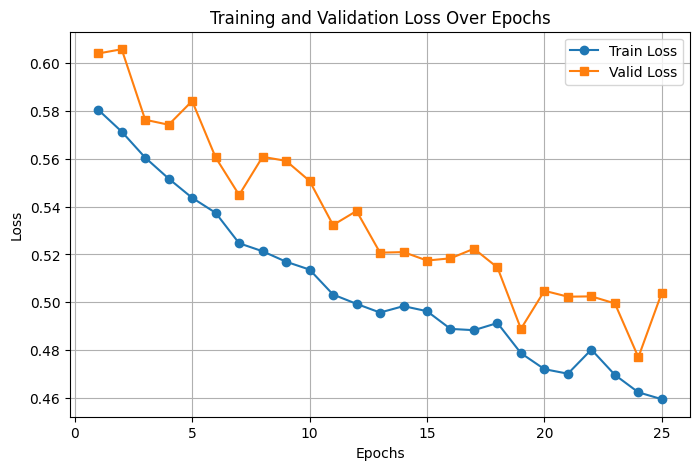

In [42]:
best_loss = np.inf
train_losses = []
valid_losses = []
for i in range(EPOCH):
  train_loss = train_fn(train_loader,model,optimizer)
  valid_loss = eval_fn(valid_loader,model)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  if valid_loss < best_loss:
    best_loss = valid_loss
    # Save the model's state_dict for inference
  torch.save({
    'model_state_dict': model.state_dict(),
  }, 'model_for_aerial_segment.pth')


  print(f'Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}')
# ✅ After training, plot the graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCH + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, EPOCH + 1), valid_losses, label="Valid Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Task 9 : Inference

In [47]:
idx = 7

checkpoint = torch.load('model_for_aerial_segment.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
image,mask = valid_dataset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0)) #logits are the raw output without sigmoid or activation function , so the model ouput is (c,h,w ) but fpr prediction it needs batch. that's wht the squeex, it will add a extra dimension for batch
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0  #making 0 and 1 for binary segmentation
pred_mask = pred_mask.detach().cpu().squeeze(0) # so for printing the predicted image we need to remove the batch.


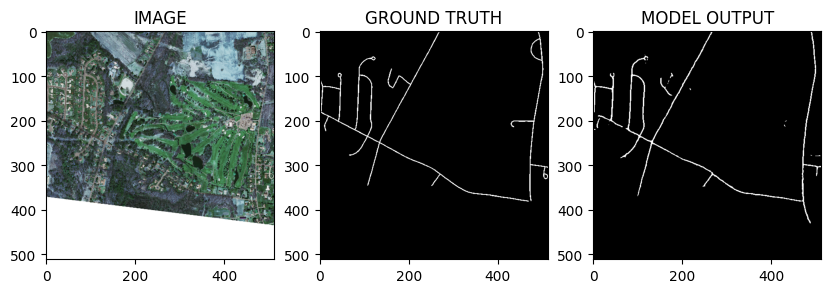

In [46]:
helper.show_image(image,mask,pred_mask)